# Adversarial Search: Playing Connect 4


## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model (result function)
* Goal state (terminal state and utility)

* __Initial state:__ Empty $6 \times 7$ board
* __Actions:__ Not full columns
* __Transition model (result function):__ Drop a disc into a not full column which is placed into lowest possible row.
* __Goal state (terminal state and utility):__ 
    * Did a player win or is the game a draw? 
    * +1 if Red wins, -1 if Yellow wins and 0 for a draw.

How big is the state space? Give an estimate and explain it.

Each of the $6 \times 7=42$ squares can have 3 values (empty, Red and Yellow), but some boards are impossible (due to gravity and rules of game).The number of states in the state space graph is less than $ 3^{42}$. [According to this MIT Connect 4 presentation](https://web.mit.edu/sp.268/www/2010/connectFourSlides.pdf), the upper bound is reduced to $7.1 \times 10^{13}$ possible states after considering that every square above an empty square is also empty. The presentation also mentions that the lower bound is estimated to be $1.6 \times 10^{13}$ possible states after considering impossible states due to the game rules.

In [1]:
3**42

109418989131512359209

How big is the game tree that minimax search will go through? Give an estimate and explain it.

[According to a research paper titled "Searching for Solutions in Games and Artificial Intelligence"](https://project.dke.maastrichtuniversity.nl/games/files/phd/SearchingForSolutions.pdf), Connect 4 has an estimated game length of 36 ply, and an average branching factor of 4, so the game-tree complexity of connect-four is
approximately $4^{36}\approx 10^{21}$

* Max depth of tree = $m = 42$ (maximal depth of 42 moves)
* Max branching factor $b = 7$ (7 different columns to make a move)


* Space complexity of $O(bm)$ (current path plus frontier)
* Time complexity of  $O(b^m)$ (number of expanded nodes)

This doesn't account for the branching factor decreases when a column becomes full.

In [2]:
# Space Complexity O(bm):
7*42

294

In [3]:
# Time Complexity O(b^m): 
7**42

311973482284542371301330321821976049

## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [4]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

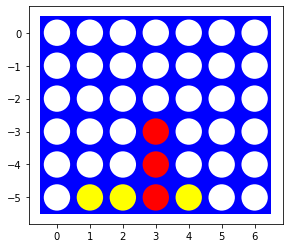

In [5]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()
    
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(s)`.
* The transition model `result(s, a)`.
* Check for terminal states `terminal(s)`.
* The utility function `utility(s)`.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [6]:
def actions(s):
    #return not full collumns
    return np.where(np.array(s[0])==0)[0].tolist()
    
def result(s, p, a):
    #check if column is full
    if(s[0][a] != 0):
        print("Error: Illegal move!")
    #copy board
    board = np.copy(s)
    #find lowest row
    lowestRow=0
    for lowestRow in range(len(board)):
        #if player disc is found
        if(board[lowestRow][a]!=0):
            #place player disc one above current disc
            board[lowestRow-1][a]=p
            #return board   
            return board
    #place player disc on lowest row
    board[lowestRow][a]=p
    #return board   
    return board

def terminal(s):
    #search board and check if it is full
    for i in range(len(s)):
        for j in range(len(s[0])):
            if s[i][j] ==0: return False
    return True

def utility(s, player = 1):
    #check if either player won
    goal = check_win(s)
    if goal == player: return +1 
    if goal == other(player): return -1
    #check if board is full
    draw = terminal(s)
    if draw: return 0
    #if game is not over
    return None

Some helper functions

In [7]:
def check_win(s):
    #copy board
    board = np.copy(s)
    #search board
    for i in range(len(board)):
        for j in range(len(board[0])):
            #check vertical
            if not i + 3 >= len(board) and board[i][j]  == board[i+1][j] == board[i+2][j] == board[i+3][j] !=0:
                return board[i][j]
            #check horizontal
            if not j + 3 >= len(board[0]) and board[i][j]  == board[i][j+1] == board[i][j+2] == board[i][j+3] !=0:
                return board[i][j]
            #check diagonal
            if not j + 3 >= len(board[0]) and not i + 3 >= len(board) and board[i][j] == board[i+1][j + 1] == board[i+2][j + 2] == board[i+3][j + 3] !=0:
                return board[i][j]
            #check check reverse diagonal
            if not j - 3 < 0 and not i + 3 >= len(board)and board[i][j] == board[i+1][j - 1] == board[i+2][j - 2] == board[i+3][j - 3] !=0:
                return board[i][j]
    #return 0 if no winner
    return 0

def other(player): 
    if player == 1: return -1
    else: return 1

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

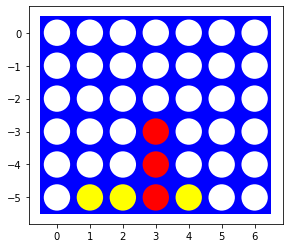

6

CPU times: total: 0 ns
Wall time: 1 ms


In [8]:
def random_player(board, player = 1):
    return np.random.choice(actions(board))

visualize(board)
%time display(random_player(board))

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [9]:
def switch_player(player, red, yellow):
    if player == 1:
        return -1, yellow
    else:
        return 1, red

def play(red, yellow, N = 1000):
    results = {1: 0, -1: 0, 'd': 0}
    for i in range(N):
        board = empty_board()
        player, fun = 1, red
        while True:
            #check if board is full
            if terminal(board):
                results['d']+=1
                break
            #get move  
            a = fun(board, player)
            board = result(board, player, a)
            #check if player won
            win = check_win(board)
            if win != 0:
                results[win] += 1
                break

            player, fun = switch_player(player, red, yellow)   
    return results

In [10]:
%time display(play(random_player, random_player))

{1: 566, -1: 431, 'd': 3}

CPU times: total: 1.62 s
Wall time: 1.61 s


Red and yellow both win about 50% of the time. However, red usually has more wins, and that could be due to red getting the first turn at the start of each game.

## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points] 

Implement minimax search starting from a given board for specifying the player.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Important Notes:__ 
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Python_Code_Examples/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.

* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [11]:
#To prevent the agent from taking too long to make a move. The agent has a max depth which controls the search tree size.

In [12]:
import math

class Alpha_beta_search:
    def __init__(self,player, maxDepth=5, debug=2):
        self.player= player
        self.maxDepth= maxDepth
        self.count= count = 0
        self.debug= debug # 1 ... count nodes, 2 ... debug each node

    def find_move(self, board):
        """start the search."""
        self.count = 0
        currentDepth=0

        value, move = self.max_value_ab(board, -math.inf, +math.inf, currentDepth)

        if self.debug >= 1: print(f"Number of nodes searched: {self.count}") 

        return { "move": move, "value": value }

    def max_value_ab(self, state, alpha, beta, currentDepth):
        """player's best move."""
        self.count += 1

        # return utility of state is a terminal state
        v = utility(state, self.player)
        if self.debug >= 2: print(f"max: {state} [alpha,beta]=[{alpha},{beta}] v={v}")
        if v is not None: 
            if self.debug >= 2: print(f"     found terminal state. backtracking.")
            return v, None
        
        #increase currentDepth and check maxDepth
        currentDepth+=1
        if currentDepth == self.maxDepth: return 0, None

        v, move = -math.inf, None

        # check all possible actions in the state, update alpha and return move with the largest value
        for a in actions(state):
            v2, a2 = self.min_value_ab(result(state, self.player, a), alpha, beta, currentDepth)
            if self.debug >= 2: print(f"max: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")

            if v2 > v:
                v, move = v2, a
                alpha = max(alpha, v)
            if v >= beta:
                if self.debug >= 2: print(f"     v>=beta ({v}>={beta}): pruning remaining subtree (actions). backtracking.")
                return v, move

        return v, move

    def min_value_ab(self, state, alpha, beta, currentDepth):
        """opponent's best response."""
        self.count += 1

        # return utility of state is a terminal state
        v = utility(state, self.player)
        if self.debug >= 2: print(f"min: {state} [alpha,beta]=[{alpha},{beta}] v={v}")
        if v is not None: 
            if self.debug >= 2: print(f"     found terminal state. backtacking.")
            return v, None
        
        #increase currentDepth and check maxDepth
        currentDepth+=1
        if currentDepth == self.maxDepth: return 0, None

        v, move = +math.inf, None

        # check all possible actions in the state, update beta and return move with the smallest value
        for a in actions(state):
            v2, a2 = self.max_value_ab(result(state, other(self.player), a), alpha, beta, currentDepth)
            if self.debug >= 2: print(f"min: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")

            if v2 < v:
                v, move = v2, a
                beta = min(beta, v)
            if v <= alpha: 
                if self.debug >= 2: print(f"     v<=alpha ({v}<={alpha}): pruning remaining subtree (actions). backtracking.")
                return v, move

        return v, move

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

### Situation 1: Red is about to win.

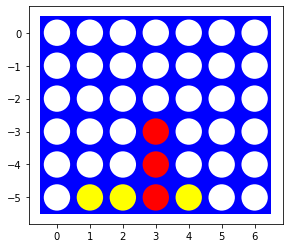

In [13]:
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]

visualize(board)

##### Red Move:

In [14]:
red_move=Alpha_beta_search(player=1, debug=1)
%time display(red_move.find_move(board))

Number of nodes searched: 236


{'move': 3, 'value': 1}

CPU times: total: 15.6 ms
Wall time: 17 ms


##### Yellow Move:

In [15]:
yellow_move=Alpha_beta_search(player=-1, debug=1)
%time display(yellow_move.find_move(board))

Number of nodes searched: 401


{'move': 3, 'value': 0}

CPU times: total: 31.2 ms
Wall time: 27 ms


Red goes for the win as planned and yellow stops the win.

### Situation 2: Yellow will win no matter what red does

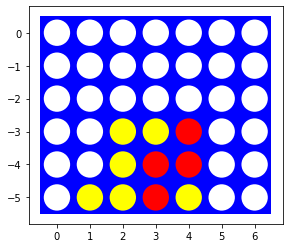

In [16]:
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0,-1,-1, 1, 0, 0],
         [0, 0,-1, 1, 1, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]

visualize(board)

##### Red Move:

In [17]:
red_move=Alpha_beta_search(player=1, debug=1)
%time display(red_move.find_move(board))

Number of nodes searched: 386


{'move': 0, 'value': -1}

CPU times: total: 15.6 ms
Wall time: 23 ms


##### Yellow Move:

In [18]:
yellow_move=Alpha_beta_search(player=-1, debug=1)
%time display(yellow_move.find_move(board))

Number of nodes searched: 159


{'move': 0, 'value': 1}

CPU times: total: 15.6 ms
Wall time: 18 ms


Red gives up because it knows it can't win. However, yellow does not pick the the shortest path to a win. If we change the max tree depth to a lower number, yellow will then pick the shortest path to a win.

### Situation 3: Empty Board

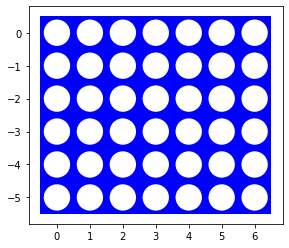

In [19]:
board = empty_board()
visualize(board)

##### Red Move:

In [20]:
red_move=Alpha_beta_search(player=1, debug=1)
%time display(red_move.find_move(board))

Number of nodes searched: 173


{'move': 0, 'value': 0}

CPU times: total: 15.6 ms
Wall time: 14 ms


##### Yellow Move:

In [21]:
yellow_move=Alpha_beta_search(player=-1, debug=1)
%time display(yellow_move.find_move(board))

Number of nodes searched: 173


{'move': 0, 'value': 0}

CPU times: total: 15.6 ms
Wall time: 13.9 ms


Both players pick the first available column. This can be changed by prioritizing other columns.

### Situation 4: Yellow is about to win.

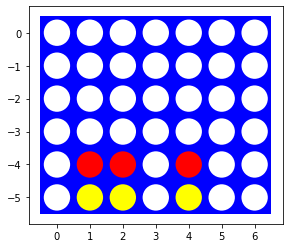

In [22]:
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 1, 1, 0, 1, 0, 0],
         [0,-1,-1, 0,-1, 0, 0]]

visualize(board)

##### Red Move:

In [23]:
red_move=Alpha_beta_search(player=1, debug=1)
%time display(red_move.find_move(board))

Number of nodes searched: 422


{'move': 3, 'value': 0}

CPU times: total: 31.2 ms
Wall time: 30 ms


##### Yellow Move:

In [24]:
yellow_move=Alpha_beta_search(player=-1, debug=1)
%time display(yellow_move.find_move(board))

Number of nodes searched: 248


{'move': 3, 'value': 1}

CPU times: total: 15.6 ms
Wall time: 18.9 ms


Red goes for column 3 to prevent yellow from winning. Yellow goes for the win.

### Situation 5: Red will win no matter what yellow does

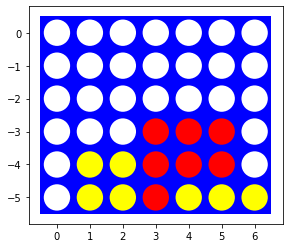

In [25]:
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 1, 1, 0],
         [0,-1,-1, 1, 1, 1, 0],
         [0,-1,-1, 1,-1,-1,-1]]

visualize(board)

##### Red Move:

In [26]:
red_move=Alpha_beta_search(player=1, debug=1)
%time display(red_move.find_move(board))

Number of nodes searched: 148


{'move': 0, 'value': 1}

CPU times: total: 15.6 ms
Wall time: 10 ms


##### Yellow Move:

In [27]:
yellow_move=Alpha_beta_search(player=-1, debug=1)
%time display(yellow_move.find_move(board))

Number of nodes searched: 312


{'move': 0, 'value': -1}

CPU times: total: 46.9 ms
Wall time: 20 ms


Red does not pick the the shortest path to a win. If we change the max tree depth to a lower number, yellow will then pick the shortest path to a win. Yellow gives up because it knows it can't win. 

### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

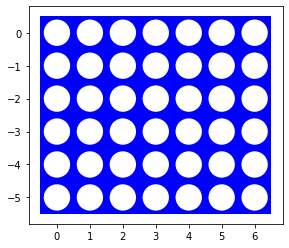

[3, 4, 2, 6, 0, 5, 1]

In [28]:
def actions(s):
    #get not full collumns
    actions = np.where(np.array(s[0])==0)[0].tolist()
    #prioritize center columns then edges
    priority = [1,0,2,3,2,0,1]
    priority = [priority[i] for i in actions]
    
    actions =[a for _,a in sorted(zip(priority,actions), reverse=True)]

    return actions

board = empty_board()   
visualize(board)
actions(board)

### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

In [29]:
#To handle this, I set a max depth for the search tree so that the search won't have to discover the entire game tree.
#The default max depth value is currently 5.

### Playtime [5 points]

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [30]:
def alpha_beta_player(board, player = 1, debug=0):
    ab_player=Alpha_beta_search(player=player, debug=debug)
    return ab_player.find_move(board)["move"]

print("alpha-beta vs. random:")
%time display(play(alpha_beta_player, random_player))

print()
print("random vs. alpha-beta")
%time display(play(random_player, alpha_beta_player))

alpha-beta vs. random:


{1: 999, -1: 1, 'd': 0}

CPU times: total: 58.5 s
Wall time: 58.4 s

random vs. alpha-beta


{1: 8, -1: 992, 'd': 0}

CPU times: total: 1min 9s
Wall time: 1min 9s


This is not the best way to test the Minimax Search agent because it will win every game just by stacking pieces up the middle column unless the random agent also places a piece in the middle column which is up to chance.

In [31]:
print("alpha-beta vs. alpha-beta")
%time display(play(alpha_beta_player, alpha_beta_player,N=100))

alpha-beta vs. alpha-beta


{1: 0, -1: 0, 'd': 100}

CPU times: total: 23.2 s
Wall time: 23.1 s


When the Minimax Search agent plays itself as an opponent, every game will result in a tie. This is the result of never introducing a random move into the game for either agent. Finding a way to provide random actions while also prioritizing columns will fix this issue.

## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function.

In [32]:
# Your code/ answer goes here.

### Cutting off search [10 points]

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [33]:
# Your code/ answer goes here.

Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [34]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [35]:
# Your code/ answer goes here.

### Playtime [5 points]

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [36]:
# Your code/ answer goes here.

## Challenge task [+ 10 bonus point will be awarded separately]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+10 bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above. 

In [37]:
# Your code/ answer goes here.

### Best First Move

Use Oure Monte Carlo Search to determine what the best first move is? Describe under what assumptions this is the "best" first move.  

In [38]:
# Your code/ answer goes here.